# Generate Adversarial Samples for Deep Learning Models with the Adversarial Robustness Toolbox (ART)

This notebook shows how to use adversarial attack techniques from the [Adversarial Robustness Toolbox (ART)](https://developer.ibm.com/code/open/projects/adversarial-robustness-toolbox/) on Deep Learning models trained with *FfDL*. The *ART* library supports crafting and analyzing various attack and defense methods for deep learning models. 

In this notebook, you will learn how to incorporate one of the attack methods supported by *ART*, the *Fast Gradient Method* (*FGM*), into your training pipeline to generate adversarial samples for the purposes of evaluating the robustness of the trained model. The model is a Convolutional Neural Network (CNN) trained on the *[MNIST handwritten digit data](http://yann.lecun.com/exdb/mnist/)* using [Keras](https://keras.io/) with a [TensorFlow](https://www.tensorflow.org/) backend.

The *ART* Github repository can be found here - https://github.com/IBM/adversarial-robustness-toolbox

This notebook uses Python 3.


## Contents

1.	[Set up the environment](#setup)
2.	[Create a Keras model](#model)
3.  [Train the model](#train)
4.	[Generate adversarial samples for a robustness check](#art)
5.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

It is recommended that you run this notebook inside a Python 3 virtual environment. Make sure you have all required libraries installed.

To store model and training data, this notebook requires access to a Cloud Object Storage (COS) instance. [BlueMix Cloud Object Storage](https://console.bluemix.net/catalog/services/cloud-object-storage) offers a free *lite plan*. Follow [these instructions](https://dataplatform.ibm.com/docs/content/analyze-data/ml_dlaas_object_store.html) to create your COS instance and generate [service credentials](https://console.bluemix.net/docs/services/cloud-object-storage/iam/service-credentials.html#service-credentials) with [HMAC keys](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials).


**Enter your cluster and object storage information:**

In [1]:
user_data = {
    "ffdl_cluster_name"          : "",    # Name of your Kubernetes cluster with FfDL deployed on it
    "vm_type"                    : "",    # Type of VM your Kubernetes cluster is deployed on ['none'|'minikube'|'ibmcloud']
    "cos_hmac_access_key_id"     : "",    # Cloud Object Storage (AWS) Access Key ID
    "cos_hmac_secret_access_key" : "",    # Cloud Object Storage (AWS) Secret Access Key
    "cos_service_endpoint"       : "",    # Cloud Object Storage endpoint, i.e. 'https://s3-api.us-geo.objectstorage.softlayer.net'
    "cos_region_name"            : ""     # Cloud Object Storage endpoint, i.e. 'us-east-1'
}

In [2]:
unset_vars = [key for (key, value) in user_data.items() if not value]

for var in unset_vars:
    print("Dictionary 'user_data' is missing '%s'" % var)
    
assert not unset_vars, "Enter 'user_data' to run this notebook!"

### 1.1. Verify or Install Required Python Libraries

In [3]:
import sys

def is_venv():
    return (hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

try:
    import keras, tensorflow, requests, wget, boto3, art
    print("All required libraries are installed.")
    !cat requirements.txt
except ModuleNotFoundError:
    if is_venv:
        print("Installing required libraries into virtual environment.")
        !python -m pip install -r requirements.txt
    else:
        print("Please install the required libraries.")
        !cat requirements.txt

Using TensorFlow backend.


All required libraries are installed.
keras>=2.1.6
tensorflow>=1.8
ipython>=5.0.0
jupyter>=1.0.0
requests>=2.12.0,<=2.18.4
wget
boto3
git+git://github.com/IBM/adversarial-robustness-toolbox@master


### 1.2. Connect to Cloud Object Storage  (COS)

Create a `boto3.resource` to interact with the COS instance. The `boto3` library allows Python developers to manage Cloud Object Storage (COS).

In [4]:
cos = boto3.resource("s3", 
                     aws_access_key_id     = user_data["cos_hmac_access_key_id"],
                     aws_secret_access_key = user_data["cos_hmac_secret_access_key"],
                     endpoint_url          = user_data["cos_service_endpoint"],
                     region_name           = user_data["cos_region_name"]
)

In [5]:
# for bucket in cos.buckets.all():
#     print(bucket.name)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [6]:
from uuid import uuid4

bucket_uid             = str(uuid4())
training_data_bucket   = 'training-data-' + bucket_uid
training_result_bucket = 'training-results-' + bucket_uid

def create_buckets(bucket_names):
    for bucket in bucket_names:
        print('Creating bucket "{}" ...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except boto3.exceptions.botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

buckets = [training_data_bucket, training_result_bucket]

create_buckets(buckets)


Creating bucket "training-data-3dab62c6-8696-49ac-b4fe-2abba301aa92" ...
Creating bucket "training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92" ...


Now you should have 2 buckets.

### 1.3. Download MNIST Training Data and Upload it to the COS Buckets

Download the training data and upload it to the `training-data` bucket.
First, create a list of links for the training dataset.

In [7]:
# Training data links
data_links = ['https://s3.amazonaws.com/img-datasets/mnist.npz']

The code in the next cell uploads files from links to your COS.

In [8]:
# Upload files to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(training_data_bucket)

for data_link in data_links:
    filename = data_link.split('/')[-1]
    print('Uploading data {} ...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data mnist.npz ...
mnist.npz is uploaded.


Have a look at the list of the created buckets and their contents.

In [9]:
def print_bucket_contents(buckets):
    for bucket_name in buckets:
        print(bucket_name)
        bucket_obj = cos.Bucket(bucket_name)
        for obj in bucket_obj.objects.all():
            print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

print_bucket_contents(buckets)

training-data-3dab62c6-8696-49ac-b4fe-2abba301aa92
  File: mnist.npz, 11221.13kB
training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92


You are done with COS, and you are ready to train your model!

<a id="model"></a>
## 2. Create the Keras model

In this section we:

- [2.1 Package the model definition](#zip)
- [2.2 Prepare the training definition metadata](#manifest)


### 2.1. Create the Model Zip File <a id="zip"></a>

Let's create the model [`convolutional_keras.py`](../edit/convolutional_keras.py) and add it to a zip file.

In [10]:
script_filename  = "convolutional_keras.py"
archive_filename = 'model.zip'

In [11]:
%%writefile $script_filename

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import keras
import numpy as np
import sys
import os

batch_size = 128
num_classes = 10
epochs = 1

img_rows, img_cols = 28, 28


def main(argv):
    if len(argv) < 2:
        sys.exit("Not enough arguments provided.")
    global image_path
    i = 1
    while i <= 2:
        arg = str(argv[i])
        if arg == "--data":
            image_path = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        i += 2


if __name__ == "__main__":
    main(sys.argv)


# load mnist npz file
f = np.load(image_path)
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']
f.close()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_wt_path = os.environ["RESULT_DIR"] + "/keras_original_model.hdf5"
model.save(model_wt_path)
print("Model saved to file: %s" % model_wt_path)

model_def_path = os.environ["RESULT_DIR"] + "/keras_original_model.json"
model_json = model.to_json()
with open(model_def_path, "w") as json_file:
    json_file.write(model_json)
print("Model definition saved to file: %s" % model_def_path)


Writing convolutional_keras.py


In [12]:
import zipfile

zipfile.ZipFile(archive_filename, mode='w').write(script_filename)

  adding: convolutional_keras.py (deflated 60%)


### 2.2. Prepare the Training Definition Metadata <a id="manifest"></a>
- *FfDL* does not have a *Keras* community image so we need to `pip`-install *Keras* prior to running the `training_command` 
- Your COS credentials are referenced in the `data_stores` > `connection` data.

In [13]:
import yaml

training_command = "pip3 install keras; python3 convolutional_keras.py --data ${DATA_DIR}/mnist.npz"

manifest = {
  "name": "keras_digit_recognition",
  "description": "Hand-written Digit Recognition Training",
  "version": "1.0",
  "gpus": 0,
  "cpus": 2,
  "memory": "2Gb",
  "data_stores": [
    {
      "id": "sl-internal-os",
      "type": "s3_datastore",
      "training_data": {
        "container": training_data_bucket
      },
      "training_results": {
        "container": training_result_bucket
      },
      "connection": {
        "type": "s3_datastore",
        "auth_url":  user_data["cos_service_endpoint"],
        "user_name": user_data["cos_hmac_access_key_id"],
        "password":  user_data["cos_hmac_secret_access_key"]
      }
    }
  ],
  "framework": {
    "name": "tensorflow",
    "version": "1.5.0-py3",
    "command": training_command
  },
  "evaluation_metrics": {
    "type": "tensorboard",
    "in": "$JOB_STATE_DIR/logs/tb"
  }
}

yaml.dump(manifest, open("manifest.yml", "w"), default_flow_style=False)

## 3. Train the Model<a id="train"></a>

In this section, learn how to:
- [3.1 Setup the command line environment](#cmd_setup)
- [3.2 Train the model in the background](#backg)
- [3.3 Monitor the training log](#log)
- [3.4 Cancel the training](#cancel)

### 3.1. Setup the Command Line Environment <a id="cmd_setup"></a>

Load the Kubernetes cluster configuration using the [BlueMix CLI](https://console.bluemix.net/docs/cli/index.html#overview). Make sure your machine is logged in with `bx login`.

In [14]:
try:
    %env VM_TYPE      {user_data["vm_type"]}
    %env CLUSTER_NAME {user_data["ffdl_cluster_name"]}
    cluster_config  = !bx cs cluster-config {user_data["ffdl_cluster_name"]} | grep "export KUBECONFIG="
    %env KUBECONFIG   {cluster_config[-1].split("=")[-1]}
except IndexError:
    print("The cluster %s could not be found." % {user_data["ffdl_cluster_name"]})
    print("Run 'bx cs clusters' to list all clusters you have access to.")
    #!bx cs clusters
    raise

env: VM_TYPE=ibmcloud
env: CLUSTER_NAME=ffdl-with-art-cluster
env: KUBECONFIG=~.bluemix/plugins/container-service/clusters/ffdl-with-art-cluster/kube-config-dal12-ffdl-with-art-cluster.yml


Setup the DLaaS URL, username and password

In [15]:
import os

notebook_dir   = os.getcwd()
ffdl_root_dir  = notebook_dir.replace("/etc/notebooks/art", "")
node_ip        = !(cd {ffdl_root_dir} && make --no-print-directory kubernetes-ip)
restapi_port   = !kubectl get service ffdl-restapi -o jsonpath='{.spec.ports[0].nodePort}'
dlaas_url      = "http://%s:%s" % (node_ip[0], restapi_port[0])

%env DLAAS_URL        $dlaas_url
%env DLAAS_USERNAME = test-user
%env DLAAS_PASSWORD = test

env: DLAAS_URL=http://169.48.201.210:30020
env: DLAAS_USERNAME=test-user
env: DLAAS_PASSWORD=test


Obtain the correct FfDL CLI for your machine

In [16]:
import platform

ffdl = "%s/cli/bin/ffdl-%s" % (ffdl_root_dir, "osx" if platform.system() == "Darwin" else "linux")

### 3.2. Start the Training Job<a id="backg"></a>


In [17]:
out = !{ffdl} train "manifest.yml" "model.zip"
out

["Deploying model with manifest 'manifest.yml' and model file 'model.zip'...",
 'Model ID: training-vIIKNQIiR',
 'OK']

### 3.3.  Monitor the Training Logs<a id="log"></a>

In [18]:
if "Model ID" in out[1]:
    model_id = out.fields()[1][-1]
    !{ffdl} logs --follow {model_id}

Getting model training logs for 'training-vIIKNQIiR'...
Status: PENDING
Status: Not Started
Training with training/test data at:
  DATA_DIR: /job/training-data-3dab62c6-8696-49ac-b4fe-2abba301aa92
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: pip3 install keras; python3 convolutional_keras.py --data ${DATA_DIR}/mnist.npz
Storing trained model at:
  RESULT_DIR: /job/training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92
Contents of $MODEL_DIR
total 12
drwxrwxrwx 2 6342627 root 4096 Jun 11 04:02 .
drwxrwxrwx 6 root    root 4096 Jun 11 04:02 ..
-rwxrwxrwx 1 6342627 root 2649 Jun 10 21:00 convolutional_keras.py
Contents of $DATA_DIR
total 11232
drwxr-xr-x 2 6342627 root     4096 Jun 11 04:02 .
drwxrwxrwx 6 root    root     4096 Jun 11 04:02 ..
-rw-r--r-- 1 6342627 root 11490434 Jun 11 04:00 mnist.npz
DATA_DIR=/job/training-data-3dab62c6-8696-49ac-b4fe-2abba301aa92
ELASTICSEARCH_PORT=tcp://172.21.40.112:9200
ELASTICSEARCH_PORT_9200_TCP=tcp://172.21.40.112:9200
ELASTICSEAR

54000/54000 [==============================] - 263s 5ms/step - loss: 0.3028 - acc: 0.9064 - val_loss: 0.0592 - val_acc: 0.9835
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Test loss: 0.06394996056337841
Test accuracy: 0.978
Model saved to file: /job/training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92/keras_original_model.hdf5
Model definition saved to file: /job/training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92/keras_original_model.json
Training process finished. Exit code: 0



## 4. Generate Adversarial Samples <a id="art"></a>

In this section, we learn how to:
- [4.1 Generate adversarial samples with ART (synchronously in notebook)](#artLocal)
- [4.2 Generate adversarial samples with ART (asynchronously using FfDL)](#artWithFfDL)

### 4.1. Generate Adversarial Samples Locally <a id="artLocal"></a>

This section shows how to use the ART Fast Gradient Method (FGM) to generate adversarial samples for the model previously trained synchronously in this notebook. 

A trained model should have been created in the `training_result_bucket`. Now ART can be used to check the robustness of the trained model. 

The original dataset used to train the model as well as the trained model serve as inputs to the `robustness_check.py` script. We can download both from the `training_data_bucket` and the `training_result_bucket` respectively.

First, download the original data set and the trained model from Cloud Object Store.

In [19]:
dataset_filename = "mnist.npz"
weights_filename = "keras_original_model.hdf5"
network_definition_filename = "keras_original_model.json"

Print contents of COS buckets used in the previous training run

In [20]:
print_bucket_contents([training_data_bucket, training_result_bucket])

training-data-3dab62c6-8696-49ac-b4fe-2abba301aa92
  File: mnist.npz, 11221.13kB
training-results-3dab62c6-8696-49ac-b4fe-2abba301aa92
  File: training-vIIKNQIiR/keras_original_model.hdf5, 14092.55kB
  File: training-vIIKNQIiR/keras_original_model.json, 2.75kB
  File: training-vIIKNQIiR/learner-1/load-data.log, 3.39kB
  File: training-vIIKNQIiR/learner-1/load-model.log, 0.42kB
  File: training-vIIKNQIiR/learner-1/training-log.txt, 41.58kB


In [21]:
# download network definition and weights to current working directory

weights_file_in_cos_bucket = os.path.join(model_id, weights_filename)
network_definition_file_in_cos_bucket = os.path.join(model_id, network_definition_filename)

bucket_obj = cos.Bucket(training_result_bucket)

bucket_obj.download_file(weights_file_in_cos_bucket, weights_filename)
print('Downloaded', weights_filename)

bucket_obj.download_file(network_definition_file_in_cos_bucket, network_definition_filename)
print('Downloaded', network_definition_filename)

Downloaded keras_original_model.hdf5
Downloaded keras_original_model.json


Download the original data set (mnist.npz)

In [22]:
# download dataset
bucket_obj = cos.Bucket(training_data_bucket)
bucket_obj.download_file(dataset_filename, dataset_filename)
print('Downloaded', dataset_filename)

Downloaded mnist.npz


Load & compile the model that we created using `convolutional_keras.py`

In [23]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import model_from_json

print('Network Definition:', network_definition_filename)
print('Weights:           ', weights_filename)

# load model
json_file = open(network_definition_filename, 'r')
model_json = json_file.read()
json_file.close()

model = model_from_json(model_json)
model.load_weights(weights_filename)
comp_params = {'loss': 'categorical_crossentropy',
                       'optimizer': 'adam',
                       'metrics': ['accuracy']}
model.compile(**comp_params)

Network Definition: keras_original_model.json
Weights:            keras_original_model.hdf5


After loading & compiling the model, the next step is to create a KerasClassifier

In [24]:
# create ART classifier object
from art.classifiers.keras import KerasClassifier

classifier = KerasClassifier((0, 1), model)

Load the test data and labels from `mnist.npz`

In [25]:
from keras.utils import np_utils

f = np.load(dataset_filename)
x_original = f['x_test']
y = f['y_test']
f.close()

Visualize the original (non-adversarial) sample

2


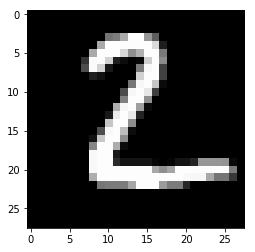

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_original[1], cmap='gray')
print(y[1])

Standardize the Numpy array

In [27]:
# preprocess
x_original = np.expand_dims(x_original, axis=3)
x_original = x_original.astype('float32') / 255
y = np_utils.to_categorical(y, 10)

Evaluate the model and calculated test accuracy

In [28]:
# evaluate
scores = model.evaluate(x_original, y, verbose=0)
print('model test loss:    ', scores[0]*100)
print('model test accuracy:', scores[1]*100)
model_accuracy = scores[1]*100

model test loss:     6.394996068091132
model test accuracy: 97.8


ART exposes many attacks like FGM, NewtonFool, DeepFool, Carlini etc. The code below shows how to use one of ART's attack methods (Fast Gradient Method or FGM) to craft adversarial samples based on x_test

In [29]:
from art.attacks.fast_gradient import FastGradientMethod

# configuration
epsilon = 0.2

# create crafter object
crafter = FastGradientMethod(classifier, eps=epsilon)

# craft samples on x_test (stored in variable x_original)
x_adv_samples = crafter.generate(x_original)

outfile = os.path.join(os.getcwd(), 'adv_samples')
np.savez(outfile, x_original=x_original, x_adversarial=x_adv_samples, y=y)

print("Number of adversarial samples crafted:", len(x_adv_samples))
print("adversarial samples saved to:", outfile)

Number of adversarial samples crafted: 10000
adversarial samples saved to: etc/notebooks/art/adv_samples


The following functions can be used for gathering metrics like model robustness, confidence metric, perturbation metric

In [30]:
import numpy.linalg as la
import json


def get_metrics(model, x_original, x_adv_samples, y):
    scores = model.evaluate(x_original, y, verbose=0)
    model_accuracy_on_non_adversarial_samples = scores[1] * 100

    y_pred = model.predict(x_original, verbose=0)
    y_pred_adv = model.predict(x_adv_samples, verbose=0)

    scores = model.evaluate(x_adv_samples, y, verbose=0)
    model_accuracy_on_adversarial_samples = scores[1] * 100

    pert_metric = get_perturbation_metric(x_original, x_adv_samples, y_pred, y_pred_adv, ord=2)
    conf_metric = get_confidence_metric(y_pred, y_pred_adv)

    data = {
        "model accuracy on test data:": model_accuracy_on_non_adversarial_samples,
        "model accuracy on adversarial samples": model_accuracy_on_adversarial_samples,
        "reduction in confidence": conf_metric * 100,
        "average perturbation": pert_metric * 100
    }
    return data


def get_perturbation_metric(x_original, x_adv, y_pred, y_pred_adv, ord=2):

    idxs = (np.argmax(y_pred_adv, axis=1) != np.argmax(y_pred, axis=1))

    if np.sum(idxs) == 0.0:
        return 0

    perts_norm = la.norm((x_adv - x_original).reshape(x_original.shape[0], -1), ord, axis=1)
    perts_norm = perts_norm[idxs]

    return np.mean(perts_norm / la.norm(x_original[idxs].reshape(np.sum(idxs), -1), ord, axis=1))


# This computes the change in confidence for all images in the test set
def get_confidence_metric(y_pred, y_pred_adv):

    y_classidx = np.argmax(y_pred, axis=1)
    y_classconf = y_pred[np.arange(y_pred.shape[0]), y_classidx]

    y_adv_classidx = np.argmax(y_pred_adv, axis=1)
    y_adv_classconf = y_pred_adv[np.arange(y_pred_adv.shape[0]), y_adv_classidx]

    idxs = (y_classidx == y_adv_classidx)

    if np.sum(idxs) == 0.0:
        return 0

    idxnonzero = y_classconf != 0
    idxs = idxs & idxnonzero

    return np.mean((y_classconf[idxs] - y_adv_classconf[idxs]) / y_classconf[idxs])

The below cell will display the following

1. Model accuracy on test data
2. Model robustness on adversarial samples
3. Reduction in confidence
4. Perturbation metric

In [31]:
result = get_metrics(model, x_original, x_adv_samples, y)

print(json.dumps(result, indent=4, sort_keys=False))

{ 
    "model accuracy on test data:": 97.8,
    "model accuracy on adversarial samples": 41.85,
    "reduction in confidence": 29.16172742843628
    "average perturbation": 47.15782701969147,
}


In [32]:
# convert the numpy array, so that the adversarial images can be visualized

x_adv = (x_adv_samples * 255).astype('int')
x_adv = x_adv[:, :, :, 0]

And visualize an adversarial sample

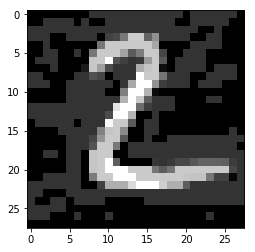

In [33]:
plt.imshow(x_adv[1], cmap='gray');

### 4.2. Generate Adversarial Samples Asynchronously using FfDL <a id="artWithFfDL"></a>

As its name suggests, FGM is a relatively short running method to generate adversarial samples. Other attack techniques can take much longer and therefore you may want to use additional computing resources and generate adversarial samples through an asynchronous Watsom ML training request. This section shows how to gather the relevant information to execute FGM as an asynchronous FfDL training job. 

Lets first create two COS buckets.

In [34]:
from uuid import uuid4

bucket_uid = str(uuid4())

robustnesscheck_data_bucket   = 'robustnesscheck-data-'    + bucket_uid
robustnesscheck_result_bucket = 'robustnesscheck-results-' + bucket_uid

buckets = [robustnesscheck_data_bucket,
           robustnesscheck_result_bucket]

create_buckets(buckets)

Creating bucket "robustnesscheck-data-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca" ...
Creating bucket "robustnesscheck-results-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca" ...


Upload all the artifacts (`mnist.npz`, `keras_original_model.json`, `keras_original_model.hdf5`) to the `robustnesscheck_data_bucket`

In [35]:
# upload

bucket_obj = cos.Bucket(robustnesscheck_data_bucket)
print("Uploading files to {}:".format(robustnesscheck_data_bucket))

bucket_obj.upload_file(dataset_filename, dataset_filename)
print('- {} was uploaded'.format(dataset_filename)) 

bucket_obj.upload_file(weights_filename, weights_filename)
print('- {} was uploaded'.format(weights_filename))

bucket_obj.upload_file(network_definition_filename, network_definition_filename)
print('- {} was uploaded'.format(network_definition_filename))

Uploading files to robustnesscheck-data-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca:
- mnist.npz was uploaded
- keras_original_model.hdf5 was uploaded
- keras_original_model.json was uploaded


Create a Python script that generates adversarial samples to check robustness using FGM (Fast Gradient Method) from the ART library

In [36]:
script_filename  = "robustness_check.py"
archive_filename = 'model.zip'

In [37]:
%%writefile $script_filename

import os
import sys
import numpy as np
import numpy.linalg as la
import json

from keras.models import model_from_json
from art.classifiers.keras import KerasClassifier
from keras.utils import np_utils
from art.attacks.fast_gradient import FastGradientMethod


def get_metrics(model, x_original, x_adv_samples, y):
    scores = model.evaluate(x_original, y, verbose=0)
    model_accuracy_on_non_adversarial_samples = scores[1] * 100

    y_pred = model.predict(x_original, verbose=0)
    y_pred_adv = model.predict(x_adv_samples, verbose=0)

    scores = model.evaluate(x_adv_samples, y, verbose=0)
    model_accuracy_on_adversarial_samples = scores[1] * 100

    pert_metric = get_perturbation_metric(x_original, x_adv_samples, y_pred, y_pred_adv, ord=2)
    conf_metric = get_confidence_metric(y_pred, y_pred_adv)

    data = {
        "model accuracy on test data:": model_accuracy_on_non_adversarial_samples,
        "model accuracy on adversarial samples": model_accuracy_on_adversarial_samples,
        "reduction in confidence": conf_metric * 100,
        "average perturbation": pert_metric * 100
    }
    return data


def get_perturbation_metric(x_original, x_adv, y_pred, y_pred_adv, ord=2):

    idxs = (np.argmax(y_pred_adv, axis=1) != np.argmax(y_pred, axis=1))

    if np.sum(idxs) == 0.0:
        return 0

    perts_norm = la.norm((x_adv - x_original).reshape(x_original.shape[0], -1), ord, axis=1)
    perts_norm = perts_norm[idxs]

    return np.mean(perts_norm / la.norm(x_original[idxs].reshape(np.sum(idxs), -1), ord, axis=1))


# This computes the change in confidence for all images in the test set
def get_confidence_metric(y_pred, y_pred_adv):

    y_classidx = np.argmax(y_pred, axis=1)
    y_classconf = y_pred[np.arange(y_pred.shape[0]), y_classidx]

    y_adv_classidx = np.argmax(y_pred_adv, axis=1)
    y_adv_classconf = y_pred_adv[np.arange(y_pred_adv.shape[0]), y_adv_classidx]

    idxs = (y_classidx == y_adv_classidx)

    if np.sum(idxs) == 0.0:
        return 0

    idxnonzero = y_classconf != 0
    idxs = idxs & idxnonzero

    return np.mean((y_classconf[idxs] - y_adv_classconf[idxs]) / y_classconf[idxs])


def main(argv):
    if len(argv) < 2:
        sys.exit("Not enough arguments provided.")

    global network_definition_filename, weights_filename, dataset_filename

    i = 1
    while i <= 8:
        arg = str(argv[i])
        print(arg)
        if arg == "--data":
            dataset_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--networkdefinition":
            network_definition_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--weights":
            weights_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--epsilon":
            epsilon = float(argv[i+1])

        i += 2

    print("dataset: ", dataset_filename)
    print("network definition: ", network_definition_filename)
    print("weights: ", weights_filename)

    # load & compile model
    json_file = open(network_definition_filename, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(weights_filename)
    comp_params = {'loss': 'categorical_crossentropy',
                   'optimizer': 'adam',
                   'metrics': ['accuracy']}
    model.compile(**comp_params)

    # create keras classifier
    classifier = KerasClassifier((0, 1), model)

    # load data set
    pf = np.load(dataset_filename)

    x = pf['x_test']
    y = pf['y_test']

    # pre-process numpy array

    x = np.expand_dims(x, axis=3)
    x = x.astype('float32') / 255

    y = np_utils.to_categorical(y, 10)

    # craft adversarial samples using FGSM
    crafter = FastGradientMethod(classifier, eps=epsilon)
    x_samples = crafter.generate(x)

    # obtain all metrics (robustness score, perturbation metric, reduction in confidence)
    metrics = get_metrics(model, x, x_samples, y)

    print("metrics : ", metrics)
    
    report_file = os.path.join(os.environ["RESULT_DIR"], "report.txt")

    with open(report_file, "w") as report:
        report.write(json.dumps(metrics))
    
    adv_samples_file = os.path.join(os.environ["RESULT_DIR"], 'adv_samples')
    print("adversarial samples saved to : ", adv_samples_file)
    np.savez(adv_samples_file, x_original=x, x_adversarial=x_samples, y=y)


if __name__ == "__main__":
    main(sys.argv)

Writing robustness_check.py


Create a zip archive to package the training script `robustness_check.py`

In [38]:
zipfile.ZipFile(archive_filename, mode='w').write(script_filename)

  adding: robustness_check.py (deflated 67%)


### Prepare Model Definition Metadata. 

The training command now points to `robustness_check.py` and four arguments are passed to the script:

1. data (`mnist.npz`)
2. networkdefinition (`keras_original_model.json`)
3. weights (`keras_original_model.hdf5`)
4. epsilon (`0.2` or `0.1`)

In [39]:
training_command = "\
pip3 install keras; \
pip3 install https://github.com/IBM/adversarial-robustness-toolbox/zipball/master; \
python3 robustness_check.py \
  --epsilon 0.2 \
  --data ${DATA_DIR}/mnist.npz \
  --networkdefinition ${DATA_DIR}/keras_original_model.json \
  --weights ${DATA_DIR}/keras_original_model.hdf5"

manifest = {
  "name": "art_robustness_check",
  "description": "Generates adversarial samples to check robustness using FGM",
  "version": "1.0",
  "gpus": 0,
  "cpus": 2,
  "memory": "2Gb",
  "data_stores": [
    {
      "id": "sl-internal-os",
      "type": "s3_datastore",
      "training_data": {
        "container": robustnesscheck_data_bucket
      },
      "training_results": {
        "container": robustnesscheck_result_bucket
      },
      "connection": {
        "type": "s3_datastore",
        "auth_url":  user_data["cos_service_endpoint"],
        "user_name": user_data["cos_hmac_access_key_id"],
        "password":  user_data["cos_hmac_secret_access_key"]
      }
    }
  ],
  "framework": {
    "name": "tensorflow",
    "version": "1.5.0-py3",
    "command": training_command
  },
  "evaluation_metrics": {
    "type": "tensorboard",
    "in": "$JOB_STATE_DIR/logs/tb"
  }
}

yaml.dump(manifest, open("manifest.yml", "w"), default_flow_style=False)

Now start the training job with FfDL

In [40]:
out = !{ffdl} train "manifest.yml" "model.zip"
out

["Deploying model with manifest 'manifest.yml' and model file 'model.zip'...",
 'Model ID: training-YHWQNQSmg',
 'OK']

In [41]:
# Monitor the training logs

if "Model ID" in out[1]:
    model_id = out.fields()[1][-1]
    !{ffdl} logs --follow {model_id}

Getting model training logs for 'training-YHWQNQSmg'...
Status: PENDING
Status: Not Started
Training with training/test data at:
  DATA_DIR: /job/robustnesscheck-data-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: pip3 install keras; pip3 install https://github.com/IBM/adversarial-robustness-toolbox/zipball/master; python3 robustness_check.py   --epsilon 0.2   --data ${DATA_DIR}/mnist.npz   --networkdefinition ${DATA_DIR}/keras_original_model.json   --weights ${DATA_DIR}/keras_original_model.hdf5
Storing trained model at:
  RESULT_DIR: /job/robustnesscheck-results-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca
Contents of $MODEL_DIR
total 16
drwxrwxrwx 2 6342627 root 4096 Jun 11 04:09 .
drwxrwxrwx 6 root    root 4096 Jun 11 04:10 ..
-rwxrwxrwx 1 6342627 root 4442 Jun 10 21:09 robustness_check.py
Contents of $DATA_DIR
total 25332
drwxr-xr-x 2 6342627 root     4096 Jun 11 04:09 .
drwxrwxrwx 6 root    root     4096 Jun 11 04:10 ..
-rw-r--r-- 1

    Running setup.py install for adversarial-robustness-toolbox: finished with status 'done'
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2018-06-11 04:10:09.390226: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
--epsilon
--data
--networkdefinition
--weights
dataset:  /job/robustnesscheck-data-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca/mnist.npz
network definition:  /job/robustnesscheck-data-9b9e2782-4b17-4930-b9a4-bbe4862dc6ca/keras_original_model.json


The above training job will create a report (`report.txt`). The file is available in COS (bucket = `robustnesscheck_result_bucket`) 

In [42]:
report_file = os.path.join(model_id, "report.txt")
bucket_obj = cos.Bucket(robustnesscheck_result_bucket)
bucket_obj.download_file(report_file, "report.txt")

with open('report.txt', "r") as report:
    result = json.load(report)
    
print(json.dumps(result, indent=4, sort_keys=False))

{
    "model accuracy on adversarial samples": 41.85,
    "model accuracy on test data:": 97.8,
    "average perturbation": 47.15782701969147,
    "reduction in confidence": 29.16172742843628
}


Download the adversarial samples that were stored to COS using the below command

In [43]:
samples_file = os.path.join(model_id, "adv_samples.npz")
print('Downloading {}/{} ...'.format(robustnesscheck_result_bucket, samples_file))
bucket_obj = cos.Bucket(robustnesscheck_result_bucket)
bucket_obj.download_file(samples_file, "adv_samples_from_cos.npz")
print('Downloaded:', "adv_samples_from_cos.npz")

Downloaded: adv_samples_from_cos.npz


Compare original with adversarial images and test model predictions

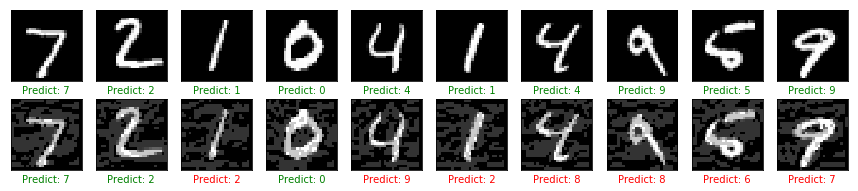

In [44]:
x_adv_samples = np.load("adv_samples_from_cos.npz")
x_original    = x_adv_samples["x_original"]
x_adversarial = x_adv_samples["x_adversarial"]
y             = x_adv_samples["y"]

x_orig = (x_original    * 255).astype('int')[:, :, :, 0]
x_adv  = (x_adversarial * 255).astype('int')[:, :, :, 0]

y_pred_orig = model.predict(x_original,    verbose=0)
y_pred_adv  = model.predict(x_adversarial, verbose=0)

fig    = plt.figure(figsize=(15, 3))
cols   = 10
rows   = 2
images = list(x_orig[:cols])      + list(x_adv[:cols])
preds  = list(y_pred_orig[:cols]) + list(y_pred_adv[:cols])
labels = list(y[:cols])           + list(y[:cols])

for i in range(0, len(images)):
    ax = fig.add_subplot(rows, cols, i+1)
    y_pred = np.argmax(preds[i])
    y_orig = np.argmax(labels[i])
    ax.set_xlabel("Predict: %s" % y_pred,
                  color = "green" if y_pred == y_orig else "red")
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')

plt.show()

## 5. Summary and Next Steps <a id="summary"></a>

This notebook only looked at one adversarial robustness technique (FGM). The *ART* library contains many more attacks, metrics and defenses to help you understand and improve your model's robustness. You can use this notebook as a template to experiment with all aspects of *ART*. Find more state-of-the-art methods for attacking and defending classifiers here:

https://github.com/IBM/adversarial-robustness-toolbox

## Acknowledgements

Special thanks to [Anupama-Murthi](https://github.ibm.com/Anupama-Murthi) and [Vijay Arya](https://github.ibm.com/vijay-arya) who created the original notebook which we modified here to showcase how to use *ART* with *FfDL*. If you would like to try *[Watson Machine Learning (WML) Service](https://console.bluemix.net/catalog/services/machine-learning)* with *ART* check out Anupama and Vijay's notebook here:

[https://github.ibm.com/robust-dlaas/ART-in-WML/Use ART to check robustness of deep learning models.ipynb](https://github.ibm.com/robust-dlaas/ART-in-WML/blob/master/Use%20ART%20to%20check%20robustness%20of%20deep%20learning%20models.ipynb)

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.